# This is notebook mainly shows the methods about halos rendering 

In [12]:
from slsim.Pipelines.halos_pipeline import HalosSkyPyPipeline
from slsim.Halos.halos_lens_base import HalosLensBase
import numpy as np
from astropy.cosmology import default_cosmology, FlatLambdaCDM
import matplotlib.pyplot as plt
from slsim.Halos.halos_plus_glass import (
    read_glass_data,
    skyarea_form_n,
    generate_samples_from_glass,
    halos_plus_glass,
    convergence_mean_0,
    run_certain_redshift_lensext_kde_by_multiprocessing,
)
import os
from slsim.Halos.halos_plus_glass import run_halos_without_kde_by_multiprocessing
import seaborn as sns
import pandas as pd

# Initializing the Halos Pipeline
Initializes the 'HalosSkyPyPipeline' with specified parameters like sky area and mass range, preparing the pipeline for halo generation and mass sheet correction calculations.
Shows the halos generated by the pipeline and plots a scatter plot of z vs. log10(mass) for the halos.

        z                 mass       
------------------ ------------------
0.5443191742787759  236891259823.1594
 4.222353009197462 123217127233.38501
 1.866420656788411 140204252856.87244
2.5571722416618416 101055924737.39825
1.7436854789114575 137948821123.07025
 1.460754088842584  334966633332.3304
1.3474791418266598  225995663773.0952
 2.946075629239195 138318231133.34653
 2.920669517336299  329744256052.7033
1.3508700522369366  152400423460.8994
               ...                ...
0.8795367695569032 183427775162.29846
2.8637061550272667 172365313984.20148
3.7429448204951083 198838496370.52277
1.8430576943195638 198646107340.55066
 4.571341411337557  133440359228.8074
1.7853931334245297 338535967103.60004
 2.422353747861696  176285195728.4188
2.9449375557145165  135131335486.4984
3.2171166456595186 372642792909.62756
0.7087993460639967  3967824254994.893
1.6425870549699455  550461513839.5739
Length = 171 rows


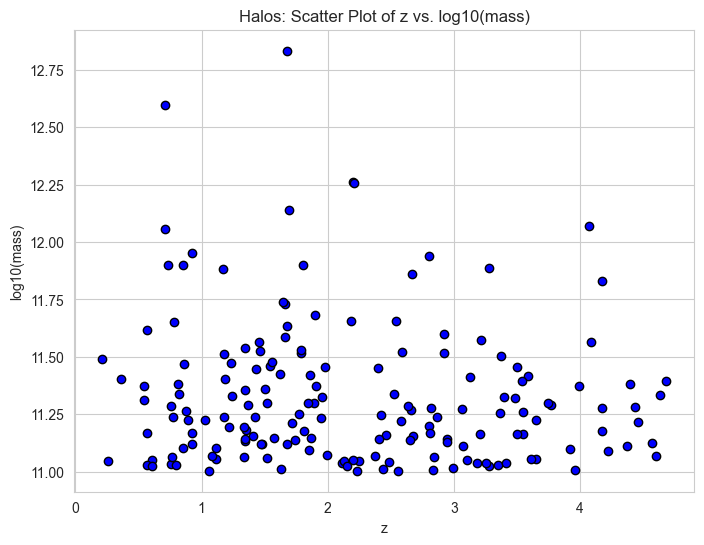

In [13]:
pipeline = HalosSkyPyPipeline(
    sky_area=0.00036,  # in square degrees
    m_max="1.0E+16",  # in solar masses
    m_min="1.0E+11",
    z_max=5.00,
)
halos = pipeline.halos
mass_sheet_correction = (
    pipeline.mass_sheet_correction
)  # calculating a negative convergence for
# mass sheet based on the average convergence of multiple halos rendering

print(halos)
z_halos = halos["z"]
mass_halos = halos["mass"]

log_mass = np.log10(mass_halos)
plt.figure(figsize=(8, 6))
plt.scatter(z_halos, log_mass, c="blue", marker="o", edgecolors="black")
plt.title("Halos: Scatter Plot of z vs. log10(mass)")
plt.xlabel("z")
plt.ylabel("log10(mass)")
plt.grid(True)

# Plotting the convergence map for the halos
## with or without mass sheet correction

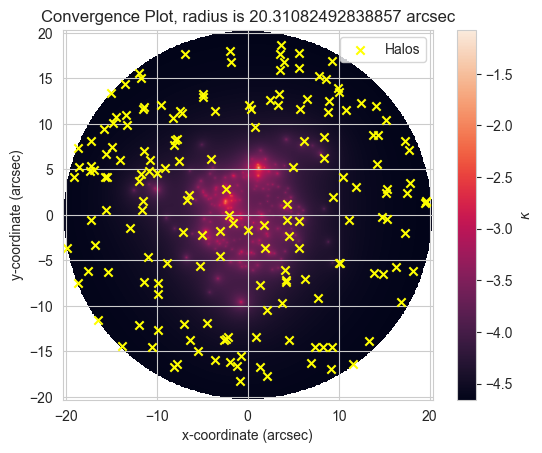

In [14]:
cosmo = FlatLambdaCDM(H0=70, Om0=0.3)

# Instantiate the HalosLens class with the halo list computed above and a defined sky area
halos_lens = HalosLensBase(
    halos_list=halos,
    mass_correction_list=mass_sheet_correction,
    mass_sheet=True,
    sky_area=0.0001,
    cosmo=cosmo,
    samples_number=1000,
)
halos_lens.plot_halos_convergence(
    diff=0.01,
)

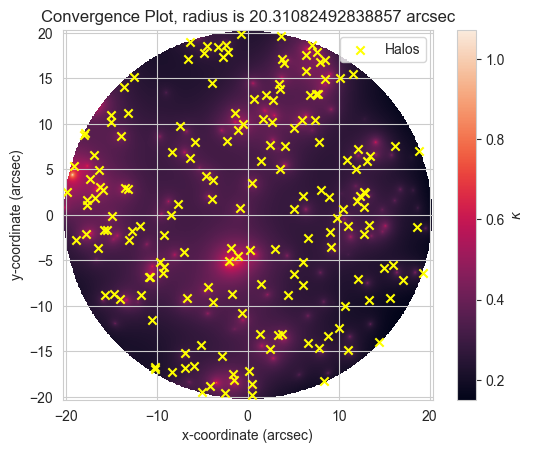

In [15]:
cosmo = FlatLambdaCDM(H0=70, Om0=0.3)

# Instantiate the HalosLens class with the halo list computed above and a defined sky area
halos_lens = HalosLensBase(
    halos_list=halos,
    mass_correction_list=None,  # No mass sheet correction
    mass_sheet=False,  # No mass sheet correction
    sky_area=0.0001,
    cosmo=cosmo,
    samples_number=1000,
)
halos_lens.plot_halos_convergence(diff=0.01)

## Render the joint contribution of external convergence and shears from halos rendering

In [5]:
halos_k, halos_g = run_halos_without_kde_by_multiprocessing(
    n_iterations=100,
    sky_area=0.00036,
    samples_number=100,
    cosmo=cosmo,
    z_max=5.0,
)

kappa_random_halos = convergence_mean_0(halos_k)
gamma_random_halos = halos_g

The 100 halo-lists took 12.880200147628784 seconds to run


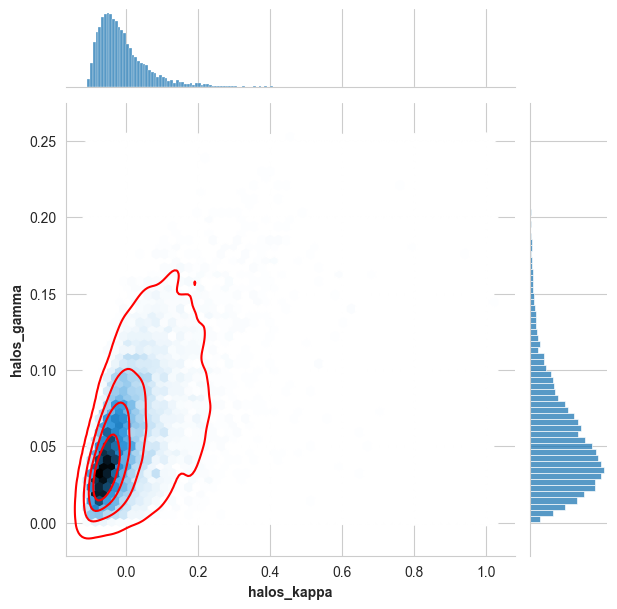

In [6]:
total_plot = sns.jointplot(x=kappa_random_halos, y=gamma_random_halos, kind="hex")
total_plot.plot_joint(sns.kdeplot, color="r", zorder=3, levels=5)
total_plot.ax_joint.set_xlabel("halos_kappa", fontweight="bold")
total_plot.ax_joint.set_ylabel("halos_gamma", fontweight="bold")
plt.show()

## Combine the halos and glass data

In [7]:
current_directory = os.getcwd()
parent_directory = os.path.dirname(current_directory)
slsim_directory = os.path.dirname(parent_directory)
file_path = os.path.join(parent_directory, "tests/TestData/kgdata.npy")

In [8]:
kappa_values, gamma_values, nside = read_glass_data(file_name=file_path)
skyarea = skyarea_form_n(nside)
kappa_random_glass, gamma_random_glass = generate_samples_from_glass(
    kappa_values, gamma_values, n=5000
)
print(kappa_random_glass.shape, gamma_random_glass.shape)

(5000,) (5000,)


In [9]:
total_kappa, total_gamma = halos_plus_glass(
    kappa_random_glass, gamma_random_glass, kappa_random_halos, gamma_random_halos
)

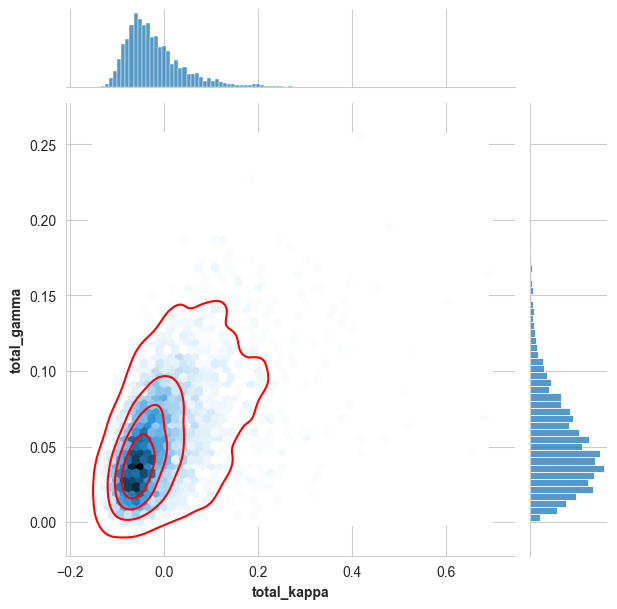

In [10]:
total_plot = sns.jointplot(x=total_kappa, y=total_gamma, kind="hex")
total_plot.plot_joint(sns.kdeplot, color="r", zorder=3, levels=5)
total_plot.ax_joint.set_xlabel("total_kappa", fontweight="bold")
total_plot.ax_joint.set_ylabel("total_gamma", fontweight="bold")
plt.show()

# Plotting the joint distribution of kappa and gamma
## with and without non-linear correction


The 300 halo-lists took 18.479110956192017 seconds to run
zs=1.5, zd=0.5,k_s_mean=-2.0435841514971593
The 300 halo-lists took 41.60276484489441 seconds to run
zs=1.5, zd=0.5,k_ext_mean=-2.329771291883323
Variance of k_S: 0.0015411077941629198
Variance of k_ext: 0.003507072856980988


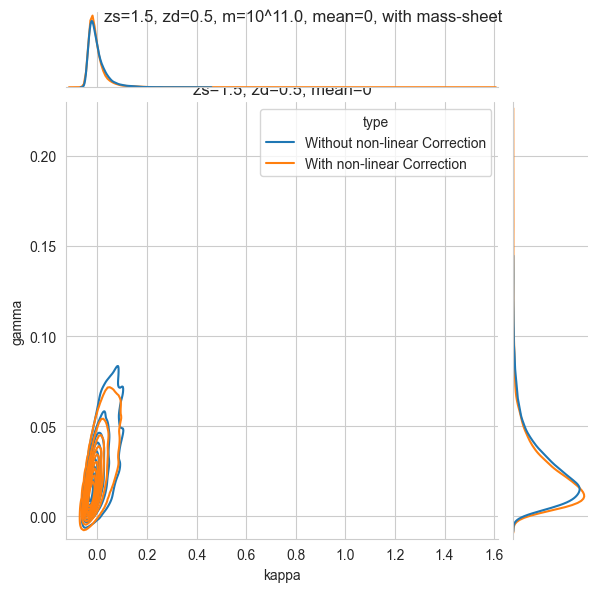

The 300 halo-lists took 35.14593505859375 seconds to run
zs=2.5, zd=0.5,k_s_mean=-3.142136416506099
The 300 halo-lists took 98.02112793922424 seconds to run
zs=2.5, zd=0.5,k_ext_mean=-2.760112978309836
Variance of k_S: 0.009450897752242038
Variance of k_ext: 0.00849273579875824


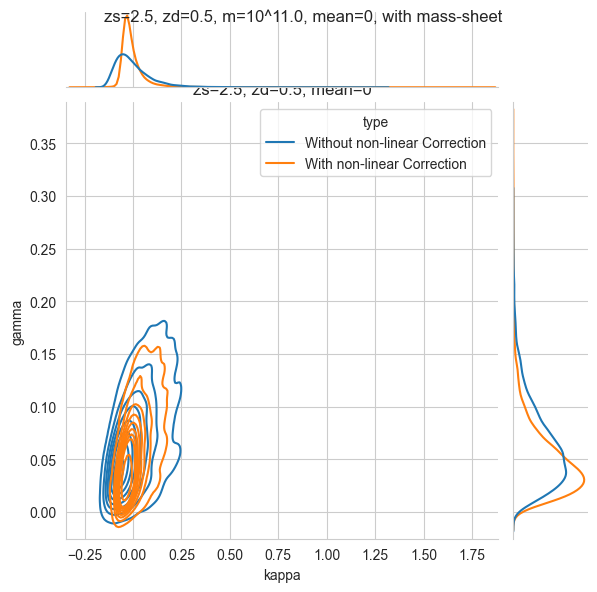

The 300 halo-lists took 15.463518857955933 seconds to run
zs=1.0, zd=0.5,k_s_mean=-1.2502118234428357
The 300 halo-lists took 30.05829882621765 seconds to run
zs=1.0, zd=0.5,k_ext_mean=-1.8764380650645613
Variance of k_S: 0.0004175112451061313
Variance of k_ext: 0.000936257280150733


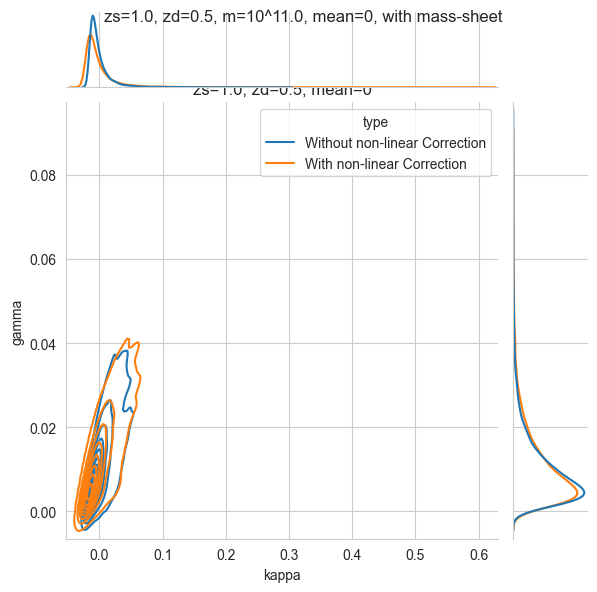

In [11]:
def plot_kappa_gamma(
    zs=1.5,
    zd=0.5,
    n_iterations=300,
    sky_area=0.00036,
    samples_number=30,
    m_min="1.0E+12",
    m_max="1.0E+16",
):
    # Setup Cosmology
    cosmo = default_cosmology.get()
    # Without Correction
    nk, ng = run_halos_without_kde_by_multiprocessing(
        n_iterations=n_iterations,
        sky_area=sky_area,
        samples_number=samples_number,
        cosmo=cosmo,
        m_min=m_min,
        m_max=m_max,
        z_max=zs,
        listmean=False,
    )
    nk_mean = sum(nk) / len(nk)
    print(f"zs={zs}, zd={zd},k_s_mean={nk_mean}")
    nk = convergence_mean_0(nk)

    # With Correction
    distribution = run_certain_redshift_lensext_kde_by_multiprocessing(
        n_iterations=n_iterations,
        sky_area=sky_area,
        samples_number=samples_number,
        cosmo=cosmo,
        m_min=m_min,
        m_max=m_max,
        z_max=zs,
        zs=zs,
        zd=zd,
        listmean=False,
    )
    nk1 = [point[0] for point in distribution]
    ng1 = [point[1] for point in distribution]
    nk1_mean = sum(nk1) / len(nk1)
    print(f"zs={zs}, zd={zd},k_ext_mean={nk1_mean}")
    nk1 = convergence_mean_0(nk1)

    # Combine Data for Joint KDE Plot
    df1 = pd.DataFrame({"x": nk, "y": ng, "type": "Without non-linear Correction"})
    df2 = pd.DataFrame({"x": nk1, "y": ng1, "type": "With non-linear Correction"})
    df_total = pd.concat([df1, df2], axis=0)

    var_nk = np.var(nk)
    var_nk1 = np.var(nk1)
    print(f"Variance of k_S: {var_nk}")
    print(f"Variance of k_ext: {var_nk1}")

    # Plotting
    plot = sns.jointplot(data=df_total, x="x", y="y", hue="type", kind="kde")

    plot.ax_joint.set_xlabel("kappa")
    plot.ax_joint.set_ylabel("gamma")
    m_min_float = float(m_min)
    plt.title(f"zs={zs}, zd={zd}, mean=0")
    plot.fig.suptitle(
        f"zs={zs}, zd={zd}, m=10^{np.log10(m_min_float)}, mean=0, with mass-sheet"
    )
    # plot.ax_joint.set_xlim(-0.2, 0.2)

    plt.show()


# To use the function:
plot_kappa_gamma(zs=1.5, zd=0.5, m_min="1.0E+11", m_max="1.0E+16")
plot_kappa_gamma(zs=2.5, zd=0.5, m_min="1.0E+11", m_max="1.0E+16")
plot_kappa_gamma(zs=1.0, zd=0.5, m_min="1.0E+11", m_max="1.0E+16")